**Predicting Stock Prices using Python and Machine Learning**

The goal is to buy stock. The aim of this project is to create a machine learning algorith determine whether the stock price increase the following day. If the algorith says the prices will increase, we will look for buys in the market. If the algorithm says that prices will go down, we won't do anything.


In [3]:
#Import finance API and get historical data

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = 'MSFT_data.json'

if os.path.exists(DATA_PATH):
  #Read from files if data was downloaded
  with open(DATA_PATH) as f:
    MSFT_hist = pd.read_json(DATA_PATH)
else:
  MSFT = yf.Ticker('MSFT')
  MSFT_hist = MSFT.history(period='max')

  #Save file to json in case we need it later.
  MSFT_hist.to_json(DATA_PATH)


In [4]:
MSFT_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060274,0.063503,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063503,0.064042,0.061350,0.061888,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0


In [5]:
#Remove timezone information

MSFT_hist = MSFT_hist.tz_localize(None)

In [6]:
MSFT_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14,0.060274,0.063503,0.060274,0.062427,308160000,0.0,0.0
1986-03-17,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18,0.063503,0.064042,0.061350,0.061888,67766400,0.0,0.0
1986-03-19,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0


<Axes: xlabel='Date'>

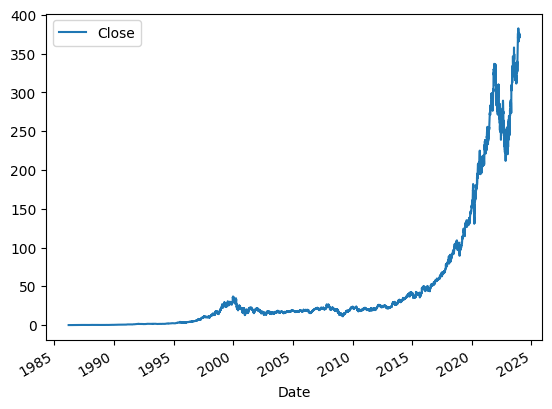

In [7]:
#Visualize the data

MSFT_hist.plot.line(y='Close', use_index=True)

**Preparing the data**

In [8]:
#Ensure we have the actual closing prices

data = MSFT_hist[['Close']]
data = data.rename(columns = {'Close':'Actual_Close'})

#Setting target

data['Target'] = MSFT_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']

In [9]:
#Shift stock prices forward one day.

MSFT_prev = MSFT_hist.copy()
MSFT_prev = MSFT_prev.shift(1)

In [10]:
#Create training data

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
data = data.join(MSFT_prev[predictors]).iloc[1:]

In [11]:
data.head(10)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.062427,1.0,0.060274,1.031789e+09,0.054893,0.062965,0.054893
1986-03-17,0.063504,1.0,0.062427,3.081600e+08,0.060274,0.063503,0.060274
1986-03-18,0.061888,0.0,0.063504,1.331712e+08,0.062427,0.064042,0.062427
1986-03-19,0.060812,0.0,0.061888,6.776640e+07,0.063503,0.064042,0.061350
1986-03-20,0.059198,0.0,0.060812,4.789440e+07,0.061888,0.062427,0.060274
1986-03-21,0.057583,0.0,0.059198,5.843520e+07,0.060812,0.060812,0.058660
1986-03-24,0.055969,0.0,0.057583,5.999040e+07,0.059198,0.060274,0.056507
1986-03-25,0.057045,1.0,0.055969,6.528960e+07,0.057583,0.057583,0.055431
1986-03-26,0.058660,1.0,0.057045,3.208320e+07,0.055969,0.057045,0.055431


**Create a Machine Learning Model**

In [13]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

#Create a random forest classification model
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

#Create train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [14]:
#Calculate the precision score

from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test['Target'], preds)

0.7272727272727273

<Axes: xlabel='Date'>

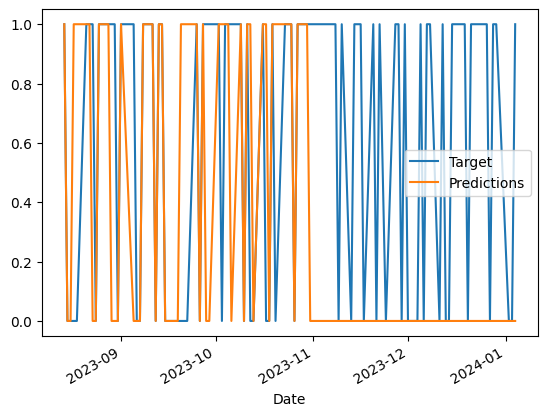

In [15]:
combined = pd.concat({'Target': test['Target'], 'Predictions': preds}, axis=1 )
combined.plot()

**Backtesting**

In [16]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []

    #Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
      #Split into train and test sets
      train = data.iloc[0:i].copy()
      test = data.iloc[i:(i+step)].copy()

      #Fit the random forest model
      model.fit(train[predictors], train['Target'])

      #Make predictions
      preds = model.predict_proba(test[predictors])[:,1]
      preds = pd.Series(preds, index=test.index)
      preds[preds > .6] = 1
      preds[preds<=.6] = 0

      #Combine predictions and test_values
      combined = pd.concat({'Target': test['Target'], 'Predictions': preds}, axis=1)

      predictions.append(combined)

    return pd.concat(predictions)


In [18]:
predictions = backtest(data, model, predictors)

In [19]:
predictions['Predictions'].value_counts()

0.0    7819
1.0     710
Name: Predictions, dtype: int64

In [20]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5084507042253521

**Improving Accuracy**

In [21]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()['Target']

In [22]:
data['weekly_mean'] = weekly_mean['Close'] /data['Close']
data['quarterly_mean'] = quarterly_mean['Close']/ data['Close']
data['annual_mean'] = annual_mean['Close'] / data['Close']

data['annual_weekly_mean'] = data['annual_mean'] / data['weekly_mean']
data['annual_quarterly_mean'] = data['annual_mean'] / data['quarterly_mean']
data['weekly_trend'] = weekly_trend

data['open_close_ratio'] = data['Open'] / data['Close']
data['high_close_ratio'] = data['High'] / data['Close']
data['low_close_ratio'] = data['Low'] / data['Close']

In [23]:
full_predictors = predictors + ['weekly_mean', 'quarterly_mean', 'annual_mean', 'annual_weekly_mean', 'annual_quarterly_mean', 'weekly_trend', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio']
predictions = backtest(data.iloc[365:], model, full_predictors)

In [24]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5394321766561514

In [25]:
#Show how many trades we would make

predictions['Predictions'].value_counts()

0.0    7847
1.0     317
Name: Predictions, dtype: int64

<Axes: xlabel='Date'>

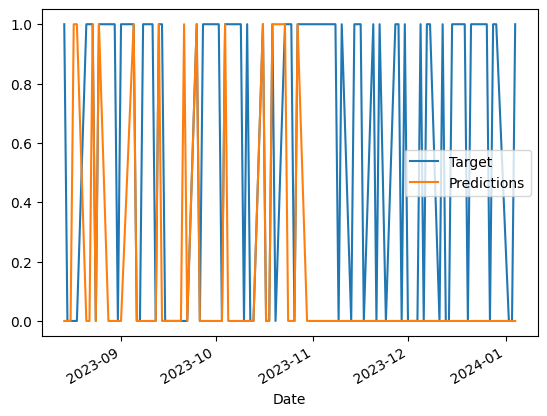

In [26]:
predictions.iloc[-100:].plot()